# Training a GPT model on protein sequences

Compared to Shakespeare, we implement a few changes:

* We want to train the model to predict protein sequences in isolation from one another; i.e. independent of the sequences shown before.
* We want to handle the case where proteins have variables sizes, and some are shorter than the block size. To handle variable-sized proteins in batches we'll use padding with a special token and mask it later on to block the attention mechanism from/to this special token.
* We want to use PyTorch Lightning to make our life a little easier.

In [1]:
import torch
import time
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from nano_transformer import NanoTransformer


fname = "data/prot_seqs.txt"

# hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 32 if device == "cpu" else 64
block_size = 8 if device == "cpu" else 256  # context size
n_embd = 16 if device == "cpu" else 384  # called d_model in paper
n_blocks = 2 if device == "cpu" else 6  # number N of transformer blocks
# head_size = 32  # called d_k = d_v
num_heads = 2 if device == "cpu" else 6  # nr attention heads
dropout = 0.2
max_iters = 5000
eval_interval = 500 if device == "cpu" else 10
learning_rate = 1e-3 if device == "cpu" else 3e-4

eval_iters = 200
print(f"device: {device}")

device: cpu


In [2]:
with open(fname, "r") as f:
    lines = f.readlines()

### Encoding amino acid tokens

Note: There are 24 amino acids in this dataset.
`{'U', 'X', 'O', 'Z'}` are present but not "commonly" known amino acids
See: https://en.wikipedia.org/wiki/FASTA_format for meaning.

In addition:
* `\n` means "end of protein"
* `!` is our special padding token

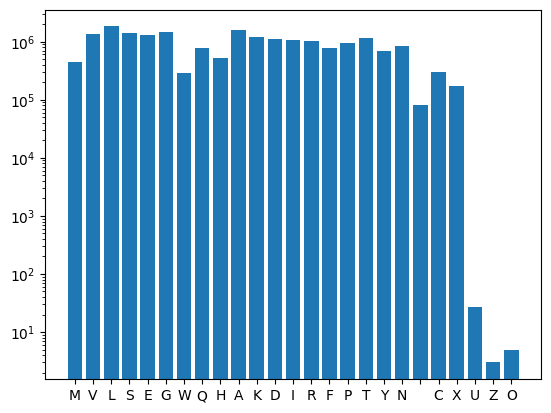

In [3]:
pad = "!"  # padding character
flat_text = [c for line in lines for c in line]  # all proteins concatenated
chars = sorted(set(flat_text)) + [pad]
vocab_size = len(chars)
stoi = {c: i for i, c in enumerate(chars)}
itos = {i: c for i, c in enumerate(chars)}



counter = Counter(flat_text)
plt.bar(counter.keys(), counter.values(), log=True);


In [4]:
def encode(s):    
    return [stoi[c] for c in s]

def decode(i):
    return "".join([itos[ii] for ii in i])

def encode_batch(batch_lines):
    # encode with padding to either block_size+1 or max_length+1
    encodings = [encode(line) for line in batch_lines]
    max_length = max([len(line) for line in encodings])
    final_length = max(block_size+1, max_length+1)
    for encoding in encodings:
        if len(encoding) < final_length:
            encoding += [stoi[pad]] * (final_length - len(encoding))
    return encodings

### Train / val split

In [5]:
random.seed(1337)

# There is one line per protein.
# We shuffle for train/val split (done in place).
random.shuffle(lines)

n = int(0.9 * len(lines))
train_lines = lines[:n]
val_lines = lines[n:]

### Data loader

TODO: return lengths of each sequences in order to know how to mask later on

In [6]:
def get_batch(batch_size, block_size, split):
    # generate a small batch of data of inputs x and targets y
    lines_to_consider = train_lines if split == "train" else val_lines

    # ids of proteins in batch
    prot_idxs = [random.randint(0, len(lines_to_consider) - 1) for _ in range(batch_size)]
    batch_lines = [lines_to_consider[i] for i in prot_idxs]

    # encode with padding to max(block_size+1, max_length+1)
    prots_encoded = encode_batch(batch_lines)

    # get random start positions for each protein; make sure we don't fetch subsequences made of padding
    start_idxs = [random.randint(0, max(0, len(batch_lines[i]) - block_size - 1))
                  for i in range(batch_size)]
    
    # build torch tensors
    x = torch.stack([torch.tensor(prots_encoded[i][start_idxs[i] : start_idxs[i] + block_size], dtype=torch.long)
                     for i in range(batch_size)])
    y = torch.stack([torch.tensor(prots_encoded[i][start_idxs[i] + 1 : start_idxs[i] + block_size + 1], dtype=torch.long) 
                     for i in range(batch_size)])
    lengths_x = torch.tensor([len(batch_lines[i]) for i in range(batch_size)], dtype=torch.long)

    x, y, lengths_x = x.to(device), y.to(device), lengths_x.to(device)
    return x, y, lengths_x

In [7]:
random.seed(7)

x, y, l = get_batch(3, 16, "train")

print(x)
print(y)
print(l.shape)

tensor([[ 4, 14, 20, 18, 20, 17, 21, 12, 17,  6,  1, 10, 18, 17,  6, 20],
        [ 6, 10, 20, 14, 16,  6, 17, 10, 10, 10, 16, 16, 15, 10,  1,  4],
        [ 9,  8, 17,  2,  9,  1, 17,  6, 23, 18,  5, 18,  4, 23, 14, 11]])
tensor([[14, 20, 18, 20, 17, 21, 12, 17,  6,  1, 10, 18, 17,  6, 20,  7],
        [10, 20, 14, 16,  6, 17, 10, 10, 10, 16, 16, 15, 10,  1,  4, 10],
        [ 8, 17,  2,  9,  1, 17,  6, 23, 18,  5, 18,  4, 23, 14, 11, 10]])
torch.Size([3])


We need some logic to obtain a (B, T, T) mask that prevents communication between padded tokens and the other tokens:

In [8]:
# a toy example on a small batch of size B
x_tmp = torch.tensor([[1,2,3,25,25],
                      [1,2,25,25,25]])
lengths = torch.tensor([3,2])
maxlen = x_tmp.shape[1]

mask = torch.arange(maxlen)[None, :] < lengths[:, None]
print(mask)

# mask = mask.to(torch.uint8)
# print(mask)

mask = mask[:, None, :]
mask = mask & mask.transpose(-2, -1)

weights = torch.randn(2, 5, 5)
weights = weights.masked_fill(~mask, float("-inf"))


tensor([[ True,  True,  True, False, False],
        [ True,  True, False, False, False]])


### Build model

In [9]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y, Ls = get_batch(batch_size, block_size, split)
            _, loss = model(X, Y, Ls)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


torch.manual_seed(1337)
random.seed(1337)

model = NanoTransformer(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_blocks=n_blocks,
    num_heads=num_heads,
    dropout=dropout,
)
model = model.to(device)
print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

tic = time.time()
for iter in range(max_iters):
    # evaluate loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(
            f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb, lb = get_batch(batch_size, block_size, "train")

    # evaluate the loss
    logits, loss = model(xb, yb, lb)
    optimizer.zero_grad(set_to_none=None)
    loss.backward()
    optimizer.step()
print(f"training duration: {(time.time() - tic):.2f} s.")

0.007482 M parameters
step 0: train loss 3.3878, val loss 3.3752
step 500: train loss 2.8823, val loss 2.8909
step 1000: train loss 2.8728, val loss 2.8695
step 1500: train loss 2.8674, val loss 2.8674
step 2000: train loss 2.8674, val loss 2.8636
step 2500: train loss 2.8579, val loss 2.8666
step 3000: train loss 2.8521, val loss 2.8561
step 3500: train loss 2.8472, val loss 2.8519
step 4000: train loss 2.8484, val loss 2.8488
step 4500: train loss 2.8514, val loss 2.8540
training duration: 28.93 s.


In [12]:
import torch.nn.functional as F

def generate_line(model, first_char_idx, termination_token_idx):
    idx = torch.tensor([[first_char_idx]], dtype=torch.long, device=device)  # (1, 1)

    while idx[0][-1].item() != termination_token_idx:
        # length = torch.tensor([[idx.shape[1]]], dtype=torch.long, device=device)  # (1, 1)
        logits, _ = model(idx=idx[:, -block_size :])
                          # lengths=length)
        # print(logits)
        logits = logits[:, -1, :]  # (B, C)
        probs = F.softmax(logits, dim=-1)  # (B, C)
        idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
        idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        # print(idx)
    return idx[0]


In [20]:
# set numpy and torch seed for reproducibility
np.random.seed(1337)
torch.manual_seed(1337)

def generate_protein_string():
    # generate from the model
    # TODO: actually use probability for an AA to be first in a protein
    start_char_proba = {k: v / sum(counter.values()) for k, v in counter.items()}
    start_char = np.random.choice(list(start_char_proba.keys()), p=list(start_char_proba.values()))
    # context = torch.tensor([[stoi[start_char]]], dtype=torch.long, device=device)

    return decode(generate_line(model, 
                            first_char_idx=stoi[start_char],
                            termination_token_idx=stoi["\n"]).tolist()[:-1])  # remove the last \n

for _ in range(5):
    print(generate_protein_string())

EKHYQAGGRGLQLQVPELVRSPRKANTFARLKAALMKPNVSAIHFMTQKIDGMPTGKSPPTTVNVHLPSSTAIEEKPGKEFPRGRLEKGMYLDHWVLKGMDQNV
LEVNETLYMVINFILPWLPMQLTVGQTVVQDSRALQESDGGPNEKALEAYSQLKLIIMKYRVTYQIDGTFSDTKAIITGFTGAEATVKKLA
EGLLVEEGLDRPGSESAEYDLWGISHLQFYNHSSNAQILDRKRLWPAEEHEGMLRDLVAAL


0